# Image features exercise

+ 通过对输入图像的像素进行线性模型训练，可以在分类任务上得到一个不错的性能
+ 本次练习不是在原始的像素上训练线性模型，而是在从原始的像素中提取出的特征上训练，以此来提高分类性能

In [1]:
import random
import numpy as np
from utils.datasets_util import load_cifar10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data

和之前的练习一样，从disk中加载CIFAR-10数据
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [7]:
from utils.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask].astype(float)
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask].astype(float)
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask].astype(float)
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print(X_train.shape)

(49000, 32, 32, 3)


## Extract Features

+ 对于每个图像，计算HOG（方向梯度直方图，Histogram of Oriented Gradients）,以及使用[HSV空间](https://zhuanlan.zhihu.com/p/67930839)的Hue通道（色相）颜色直方图，通过组合HOG和颜色直方图特征向量，得到最终每张图的特征向量。
+ 大致来看，
    + HOG虽然会忽略颜色信息，但其可以捕获图像的纹理特征；
    + 颜色直方图表示输入图像的颜色，不过会忽略纹理信息，二者在颜色和纹理上互补。
    + 因此，我们希望同时使用两种特征比单独使用任何一个都好，可以在bonus部分验证一下这个假设。
+ `hog_feature`和`color_histogram_hsv`函数都是在单个图像上操作，返回一个表示图像的特征向量。
    + `extract_features`函数使用图像集合和特征函数列表作为输入，在每个图像上评估每个特征函数，把结果存在一个矩阵里，矩阵的每一列是一个图像组合所有特征向量后的结果。

For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [11]:
# 注意，这里要修改hog_feature函数中这个部分，需要把索引强制变成整数
# orientation_histogram[:, :, i] = uniform_filter(temp_mag, size=(cx, cy))[round(cx/2)::cx, round(cy/2)::cy].T
# 不然会报错 TypeError: slice indices must be integers or None or have an __index__ method
from utils.features import *

num_color_bins = 10 # Number of bins in the color histogram
# 函数列表，给了函数名称，color_histogram_hsv采用lambda函数的形式是因为还有个nbin参数需要指定
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

# feats: features
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
# 预处理，减去特征均值，即：zero-mean，（零均值），保证每个维度的输入有正有负
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
# 预处理，减去标准差，确保每个特征在相同的数据范围里（归一化）
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
# 预处理，添加偏置维度，这里是列方向上的拼接
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features

使用之前写的多类SVM算法，使用上面提取的特征来训练SVMs，应该会得到比基于原始像素训练的更好的结果

Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [16]:
# Use the validation set to tune the learning rate and regularization strength

from utils.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None
num_train_config=10

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
# 因为要说明和之前使用像素训练的svm比较，因此这里选择完全相同的参数
np.random.seed(1)

for num in range(num_train_config):
    lr = 10**np.random.uniform(-7, -4.3)
    reg = 10**np.random.uniform(4.39, 4.69)
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats,y_train,learning_rate=lr,reg=reg,num_iters=1500,verbose=False)
    train_acc=np.mean(svm.predict(X_train_feats)==y_train)
    val_acc=np.mean(svm.predict(X_val_feats)==y_val)
    if val_acc>best_val:
        best_val=val_acc
        best_svm=svm
    results[(lr,reg)]=(train_acc,val_acc)

# 也可以用网格搜索的方式
# learning_rates = [1e-9, 1e-7, 1e-5, 1e-3]
# regularization_strengths = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# grid_search = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

# for config,param in enumerate(grid_search):
#     lr = param[0]
#     reg = param[1]
#     svm = LinearSVM()
#     loss_hist = svm.train(X_train_feats,y_train,learning_rate=lr,reg=reg,num_iters=1500,verbose=False)
#     train_acc=np.mean(svm.predict(X_train_feats)==y_train)
#     val_acc=np.mean(svm.predict(X_val_feats)==y_val)
#     if val_acc>best_val:
#         best_val=val_acc
#         best_svm=svm
#     results[(lr,reg)]=(train_acc,val_acc)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.636156e-07 reg 2.956752e+04 train accuracy: 0.414571 val accuracy: 0.422000
lr 3.346397e-07 reg 3.376554e+04 train accuracy: 0.413020 val accuracy: 0.404000
lr 1.336471e-06 reg 4.037359e+04 train accuracy: 0.412367 val accuracy: 0.401000
lr 2.742923e-06 reg 4.721224e+04 train accuracy: 0.408755 val accuracy: 0.401000
lr 3.053344e-06 reg 2.510616e+04 train accuracy: 0.407327 val accuracy: 0.407000
lr 6.700402e-06 reg 4.366329e+04 train accuracy: 0.387898 val accuracy: 0.393000
lr 1.544030e-05 reg 2.829571e+04 train accuracy: 0.378449 val accuracy: 0.376000
lr 1.835686e-05 reg 2.808223e+04 train accuracy: 0.378245 val accuracy: 0.402000
lr 2.414958e-05 reg 3.322060e+04 train accuracy: 0.322510 val accuracy: 0.312000
lr 2.847106e-05 reg 3.608341e+04 train accuracy: 0.324204 val accuracy: 0.339000
best validation accuracy achieved during cross-validation: 0.422000


确实比用像素训练的SVM（0.39）好点，这个是0.422，提升了3%，还可以了

In [17]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


测试集：之前基于像素训练的是0.376，这里是0.421，高了5%，不错

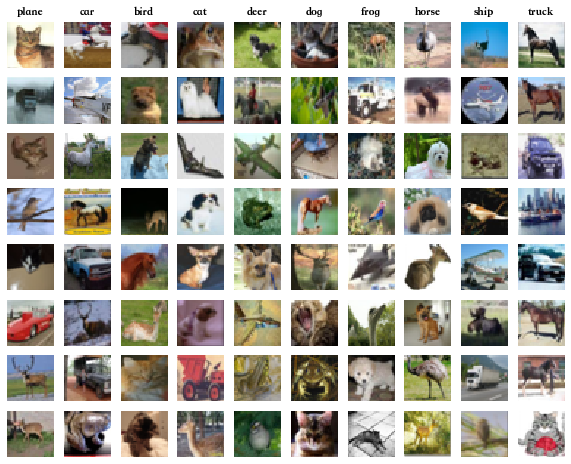

In [19]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

# 想要很好的掌握算法是如何工作的，可视化分类错误的结果是一个很好的途径
# 在下面的可视化中，展示了算法分类错误的例子，第一列显示算法分类为飞机的，但是实际不是飞机的，其他列类似。
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

描述你在这些错分结果中看到的东西，这些东西对后续网络的改进有意义吗？
+ 第一列飞机：第二和第四张图都是蓝色背景，剩下很多都是长条的东西 
+ 第二列汽车：卡车错分了两个，横向上比较长的东西
+ 第三列鸟：头小身子胖，整体偏向倾斜的椭圆形
+ 第四列猫：很多狗错分

<https://github.com/amanchadha/stanford-cs231n-assignments-2020/blob/master/assignment1/features.ipynb>
+ 偶尔会有猫、狗甚至汽车的样本出现在鸟类类别中，反之亦然。 猫、狗、鸟和其他动物具有相似的“外观”，
    + 因为它们由于共同的面部特征（眼睛、耳朵、鼻子、嘴巴）而具有相似的纹理，在某些情况下，HOG 捕捉到的是四足腿； 
    + 它们也有相似的配色方案，由颜色直方图表示。 
    + 同样，马和鹿由于相似的纹理和颜色特征而被混淆。 基于类似的论点，汽车和卡车被混淆了。 
    + 由于背景相似性，也存在一些类别不匹配 - 例如，考虑飞机类别，其中错误分类的示例在背景中具有相似性，因为天空和海洋的颜色相似，这就是它们通常与船舶图像混合的原因。
+ 总之，HOG 和颜色直方图特征向量的组合不足以以无可挑剔的精度区分这些类别。 HOG 描述符很有用，因为它考虑了图像内的纹理，但 HOG 没有考虑类内方差的类型，例如旋转、缩放、平移、照明、姿势变形等。
+ Lowe 的尺度不变特征变换 (SIFT) 可以帮助提高我们模型在这种情况下的准确性。 颜色直方图功能有助于根据配色方案区分类别。 当将颜色直方图与更高级的特征描述符（如 HOG 或 SIFT）结合使用时，我们可以降低颜色直方图的权重，以减少简单的基于颜色的类隔离问题。

In [25]:
X_train_feats.shape, X_test_feats.shape,best_svm.W.shape

((49000, 155), (1000, 155), (155, 10))

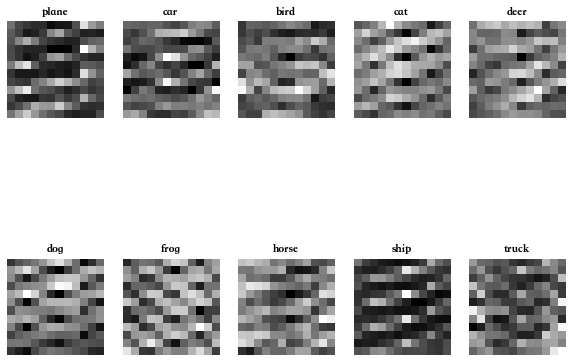

In [31]:
# 如果输入变成了特征，那查看权重其实就没有很明显的结构信息了，人不是非常能理解
# W.shape,3072*10,32*32=1024,1024*3=3072, reshape(32,32,3,10)
# w = best_svm.W[:147,:].reshape(7,7,3,10)
w = best_svm.W[:144,:].reshape(12,12,1,10)
w_min, w_max = np.min(w), np.max(w)  # 记录最大和最小值用来帮助缩放到0~255范围进行显示
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Neural Network on image features
+ 之前的练习也看到了两层神经网络基于像素训练的结果(0.52)，比线性分类器（SVMs 0.39）的效果要好
+ 同时在上面也看到了基于图像特征训练的线性分类器优于基于原始的像素训练的线性分类器
+ 为了完整期间，也应该尝试基于图像特征训练一个神经网络，这个方法的结果应该比之前的所有方法效果都好：你可以轻松的实现测试集上55%以上的准确率，我们目前已知最好的可以实现测试集60%的准确率

Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [32]:
print(X_train_feats.shape)

(49000, 155)


In [46]:
from utils.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_accuracy = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
results = {}
best_status=()

np.random.seed(1)

def random_hyperparams_search(hidden_layer_size,learning_rate,epoch,regularization):
    h_s = hidden_layer_size[np.random.randint(0,len(hidden_layer_size))]
    lr = learning_rate[np.random.randint(0,len(learning_rate))]
    epoch_size= epoch[np.random.randint(0,len(epoch))]
    reg=regularization[np.random.randint(0,len(regularization))]
    return (h_s,lr,epoch_size,reg)

hidden_layer_size_list = [150,80,100,120] 
learning_rate_list = [0.1]  # 如果是0.001，loss变化特别慢。。
iteration_list=[1960,2350] 
regularization_list = [2e-7] 

num_hyperparam_config=1
grid_search = [random_hyperparams_search(hidden_layer_size_list,learning_rate_list,iteration_list,regularization_list) for num in range(num_hyperparam_config) ]
# grid_search.append((80,0.3,3000,0))
# grid_search.append((80,0.3,3000,0.1))
grid_search.append((150,0.3,3000,2e-7))
# 隐藏层大小：150,学习率：0.1, iteration=1960, reg=0.01,训练集准确率：0.5225714285714286,验证集准确率:0.516,
# 隐藏层大小：80,学习率：0.3, iteration=3000, reg=0,训练集准确率：0.6474489795918368,验证集准确率:0.564,
# 隐藏层大小：150,学习率：0.3, iteration=3000, reg=2e-07,训练集准确率：0.6841632653061225,验证集准确率:0.588,

for hyperparam_num,hyperparam in enumerate(grid_search):
    hidden_size,learning_rate,iteration,reg = hyperparam
    print(f"第{hyperparam_num}次使用的超参组合是：隐藏层大小：{hidden_size},学习率：{learning_rate}, iteration={iteration}, reg={reg}")
    net = TwoLayerNet(input_dim, hidden_size, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=iteration, batch_size=200,
                learning_rate=learning_rate, learning_rate_decay=0.95,
                reg=reg, verbose=True)
    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    train_acc = (net.predict(X_train_feats) == y_train).mean()
    if val_acc>best_accuracy:
        best_accuracy=val_acc
        best_net=net
        best_status=stats
    results[hyperparam_num]=(val_acc,train_acc)

第0次使用的超参组合是：隐藏层大小：80,学习率：0.1, iteration=2350, reg=2e-07
iteration 0 / 2350: loss 2.302585
iteration 100 / 2350: loss 2.302797
iteration 200 / 2350: loss 2.249290
iteration 300 / 2350: loss 1.883450
iteration 400 / 2350: loss 1.671164
iteration 500 / 2350: loss 1.638993
iteration 600 / 2350: loss 1.628106
iteration 700 / 2350: loss 1.377613
iteration 800 / 2350: loss 1.329906
iteration 900 / 2350: loss 1.397247
iteration 1000 / 2350: loss 1.302151
iteration 1100 / 2350: loss 1.310078
iteration 1200 / 2350: loss 1.276951
iteration 1300 / 2350: loss 1.321186
iteration 1400 / 2350: loss 1.352452
iteration 1500 / 2350: loss 1.259369
iteration 1600 / 2350: loss 1.329830
iteration 1700 / 2350: loss 1.414820
iteration 1800 / 2350: loss 1.392914
iteration 1900 / 2350: loss 1.376654
iteration 2000 / 2350: loss 1.341460
iteration 2100 / 2350: loss 1.348914
iteration 2200 / 2350: loss 1.260750
iteration 2300 / 2350: loss 1.261127
第1次使用的超参组合是：隐藏层大小：150,学习率：0.3, iteration=3000, reg=2e-07
iteration 0

In [47]:
for hyperparam_num, acc in sorted(results.items(),key=lambda kv:(kv[1], kv[0])):
    hidden_size,learning_rate,iteration,reg = grid_search[hyperparam_num]
    val_acc,train_acc = acc
    print(f"隐藏层大小：{hidden_size},学习率：{learning_rate}, iteration={iteration}, reg={reg},训练集准确率：{train_acc},验证集准确率:{val_acc},")

隐藏层大小：80,学习率：0.1, iteration=2350, reg=2e-07,训练集准确率：0.5595102040816327,验证集准确率:0.54,
隐藏层大小：150,学习率：0.3, iteration=3000, reg=2e-07,训练集准确率：0.6841632653061225,验证集准确率:0.588,


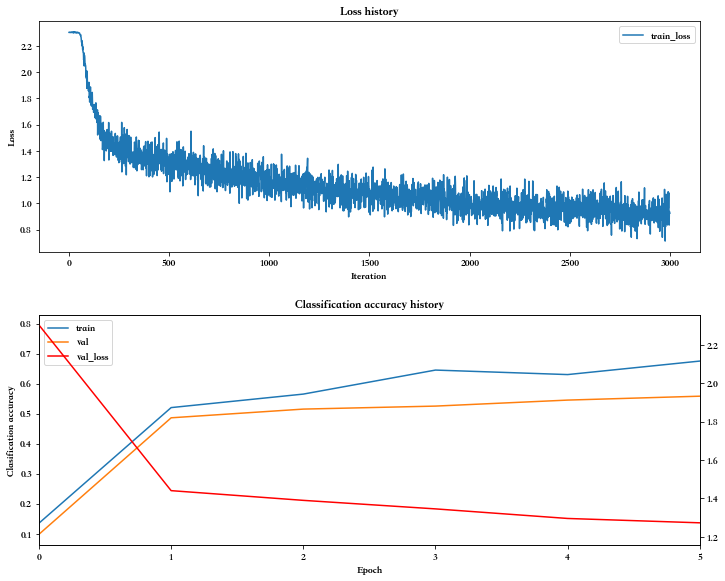

In [48]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(stats['loss_history'],label='train_loss')
axs[0].set_title('Loss history')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plt.tight_layout(pad=4)
plt.tight_layout(h_pad=3,w_pad=1.08)
l1=axs[1].plot(stats['train_acc_history'], label='train')
l2=axs[1].plot(stats['val_acc_history'], label='val')
axs[1].set_title('Classification accuracy history')
axs[1].set_xlabel('Epoch')
axs[1].set_xlim(0,5)
ax2 = axs[1].twinx() 
l3=ax2.plot(stats['val_loss_history'], label='val_loss',color='red')
axs[1].set_ylabel('Clasification accuracy')
axs[1].legend(handles=l1+l2+l3)
plt.show()

In [49]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
# 在测试集上运行你的神经网络分类器，可以得到大于55%的准确率
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.573


# Bonus: Design your own features!
**加分项：设计你自己的features**
+ 你已经看到了简单的图像特征可以提高分类的效果，迄今为止我们尝试了HOG和颜色梯度，其它类型的特征可能会实现更高的分类性能
+ 要得到额外的加分，设计并实现一个新的特征，把它用在CIFAR-10的图像分类任务上，解释一下你的特征是如何工作的，为什么你觉得它对图像分类任务有效，在本notebook中实现，交叉验证超参，并且比较它与HOG+颜色梯度的基线的性能

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!